In [66]:
# sudo docker run -it -p 8888:8888 dockerrevivemed/mz_embed_engine:v1.4 /bin/bash
# jupyter lab --ip 0.0.0.0 --port 8888 --no-browser --allow-root

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import umap
import requests
import zipfile
from google.cloud import storage
import gcsfs
# import mysql.connector
# from mysql.connector.constants import ClientFlag
from google.cloud import storage

2024-09-18 20:08:04.565135: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-18 20:08:04.601292: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-18 20:08:04.612353: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-18 20:08:04.641760: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


<font size="5"><b>Functions</b></font>

In [3]:
import os
os.chdir('/home/leilapirhaji/mz_embed_engine/study_alignment')
from utils_QC import *


<font size="5"><b>Dowanload Datasets to local from Drop Box</b></font>

In [5]:
# create input and output data dir
homedir = "/app"
input_data_dir = f'{homedir}/INPUT_DATA'
os.makedirs(input_data_dir, exist_ok=True)
print(input_data_dir)
output_dir = f'{homedir}/PROCESSED_DATA'
os.makedirs(output_dir, exist_ok=True)
print(output_dir)

# download datasets and metadata from dropbox to input_data_dir
# https://www.dropbox.com/scl/fo/9xtdsndm39mwxw3p3hrjs/AKjY7SDKdjmu1Ne1oYviLpk?rlkey=xc2xwzj5ky3jzm4q7ec8t6rd9&st=d7berzpw&dl=0
drop_box_data_url = "https://www.dropbox.com/scl/fo/9xtdsndm39mwxw3p3hrjs/AKjY7SDKdjmu1Ne1oYviLpk?rlkey=qq4s1e3s20rdbd1e78rsk04n6&dl=1"
download_data_dir(drop_box_data_url, save_dir=input_data_dir)

/app/INPUT_DATA
/app/PROCESSED_DATA


In [56]:
# all mzlearn run folder name to mzlearn run id dict
mzlearn_run_input_folder_names2mzlearn_run_id = {'ST000388': 581,
                                                 'ST000422': 550,
                                                 'ST000601': 547,
                                                 'ST000909': 556,
                                                 'ST001236': 589,
                                                 'ST001237': 590,
                                                 'ST001408': 522,
                                                 'ST001422': 502,
                                                 'ST001423': 526,
                                                 'ST001428': 503,
                                                 'ST001519': 605,
                                                 'ST001849': 504,
                                                 'ST001918': 559,
                                                 'ST001931': 505,
                                                 'ST001932': [579,584,585,586,587,588],
                                                 'ST002027': 558,
                                                 'ST002112': 507,
                                                 'ST002244': 557,
                                                 'ST002251': 555,
                                                 'ST002331': 509,
                                                 'stanford-hmp2': 631
                                                }

<font size="5"><b>Plot PCA for all mzlearn runs</b></font>

/tmp/ipykernel_25/4123381525.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()  # Create a new figure


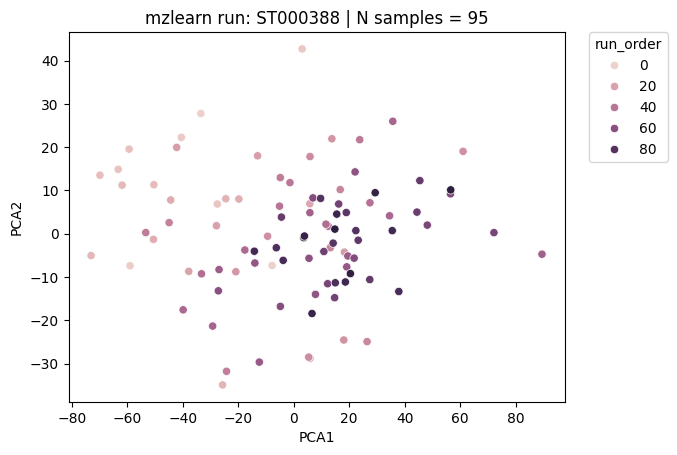

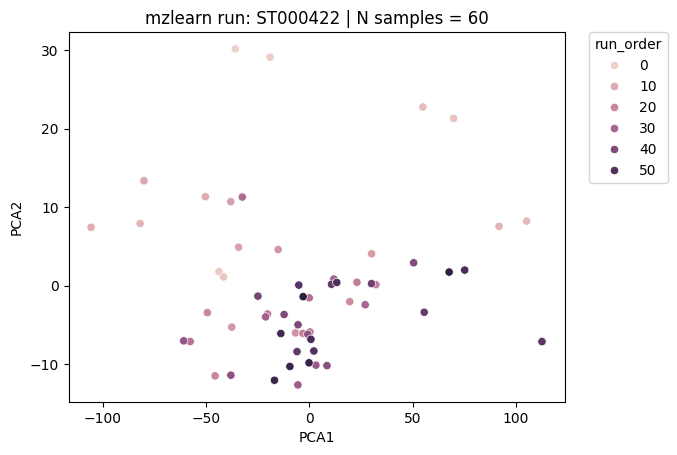

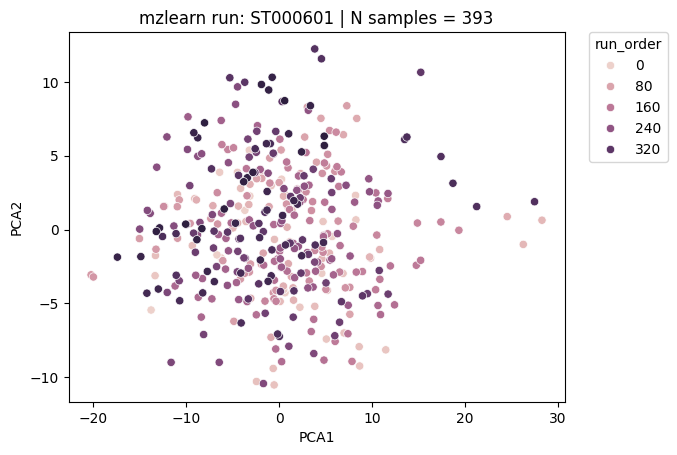

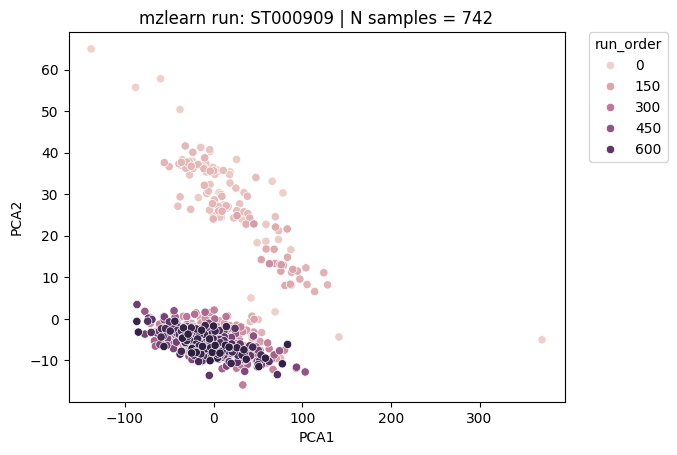

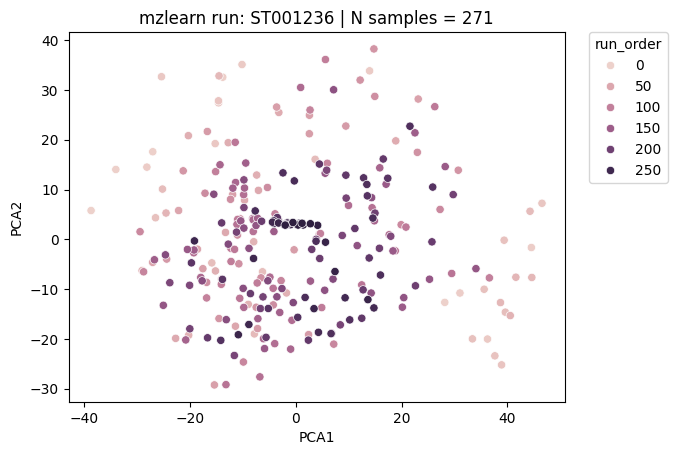

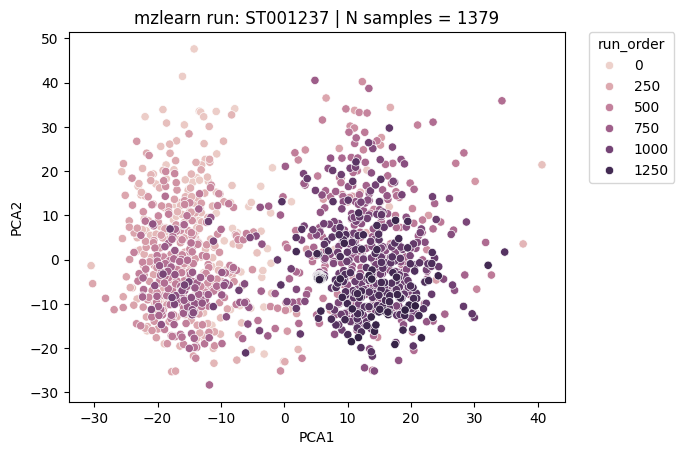

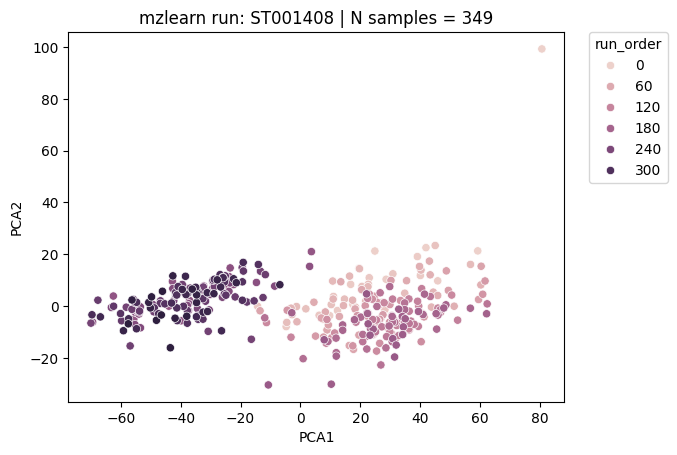

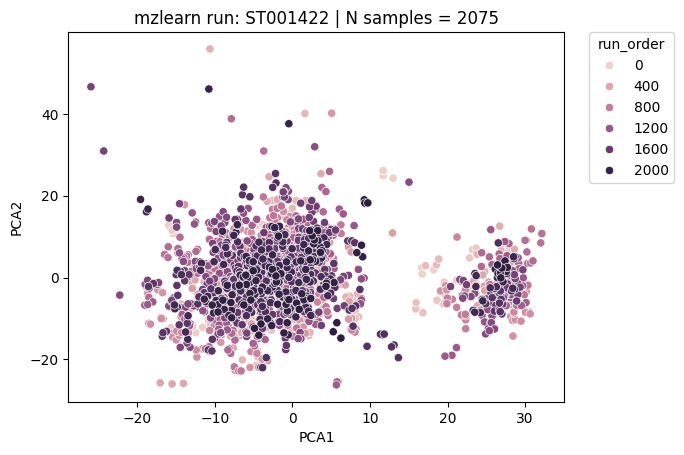

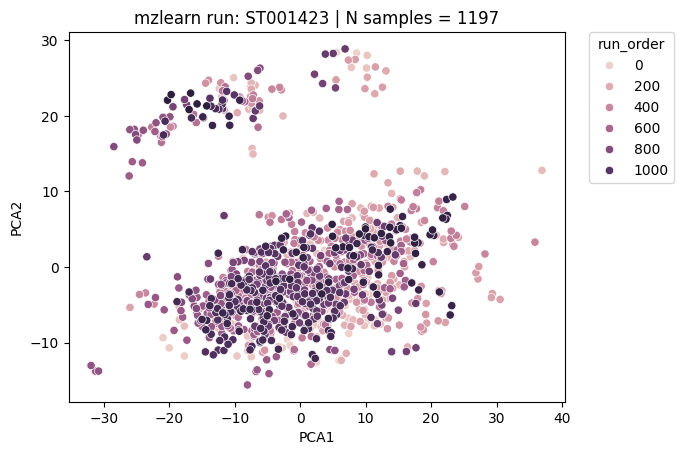

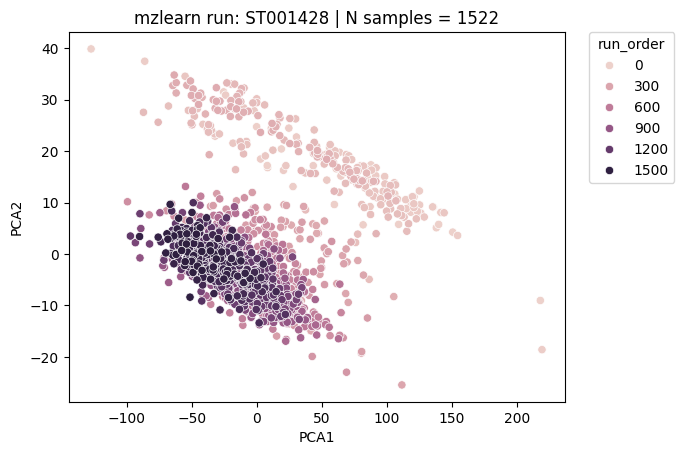

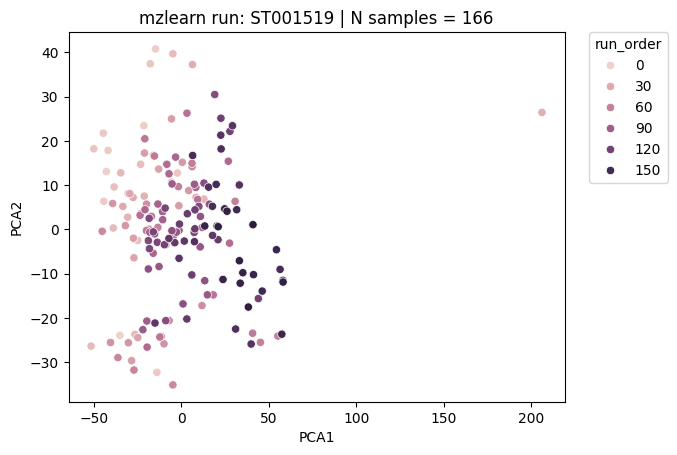

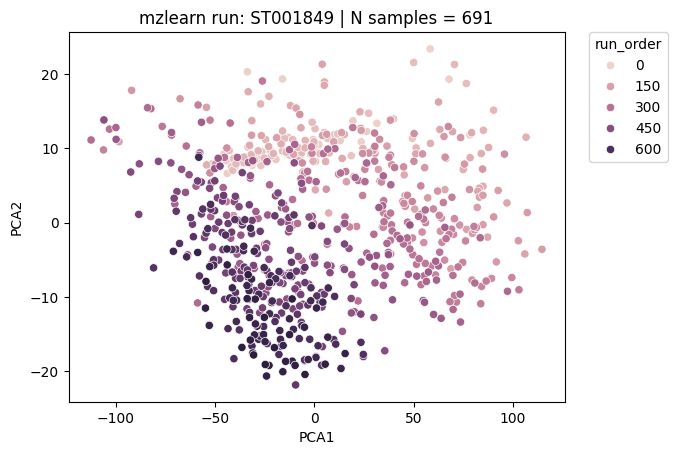

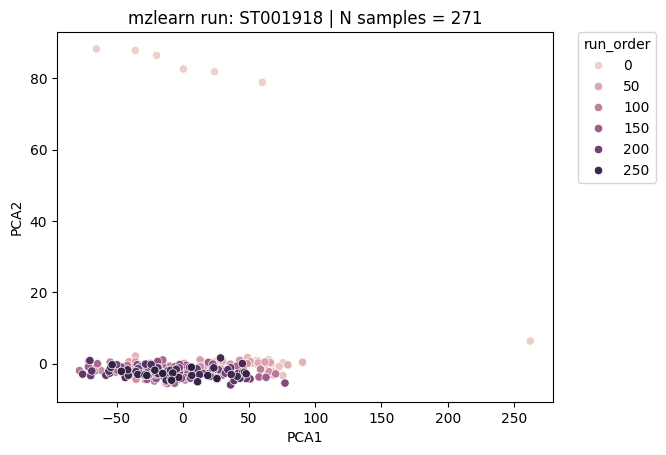

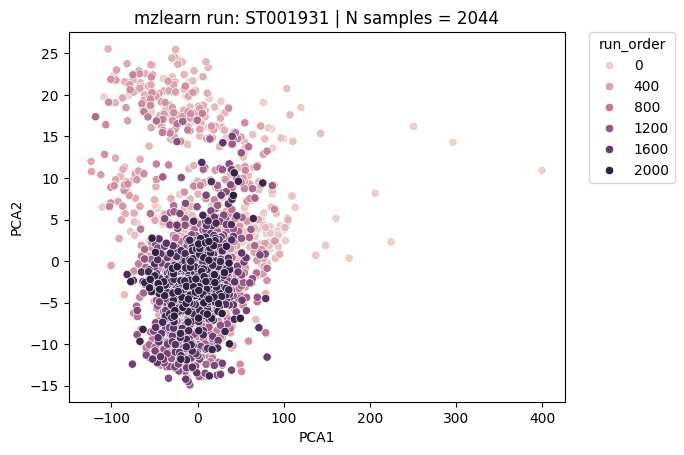

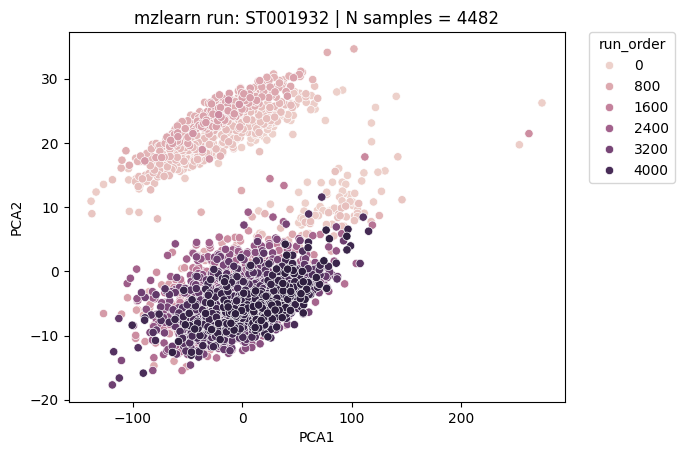

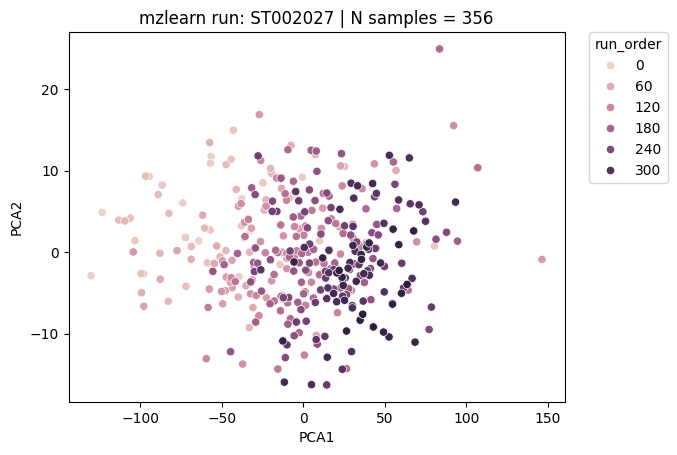

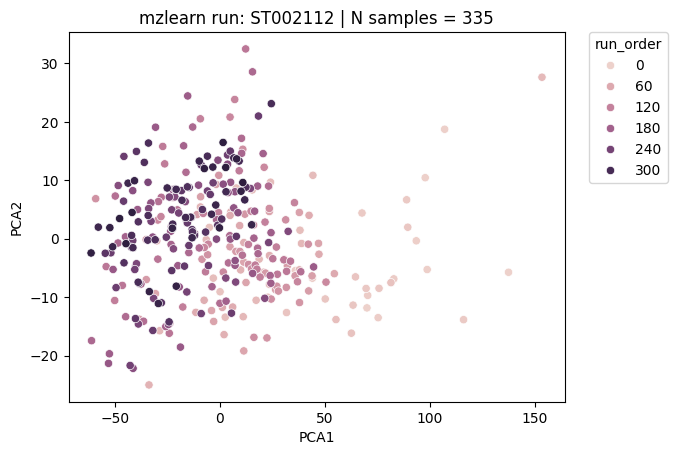

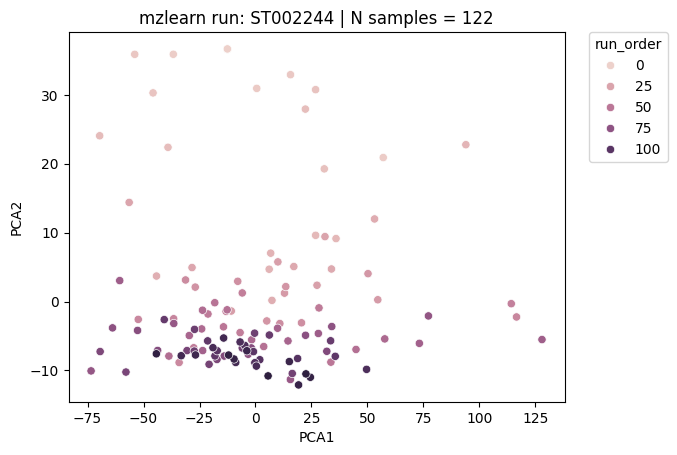

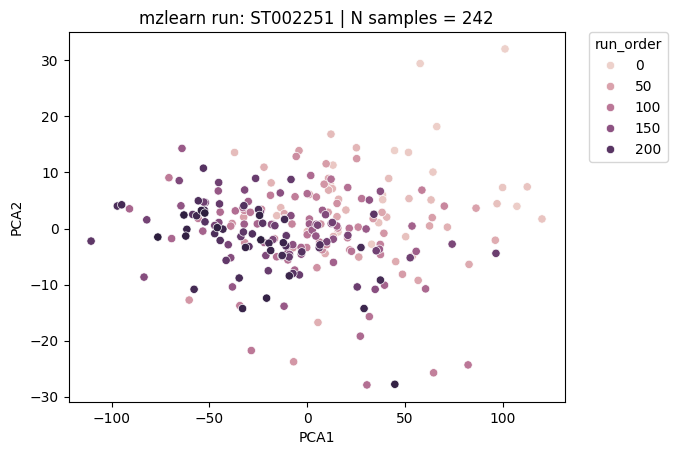

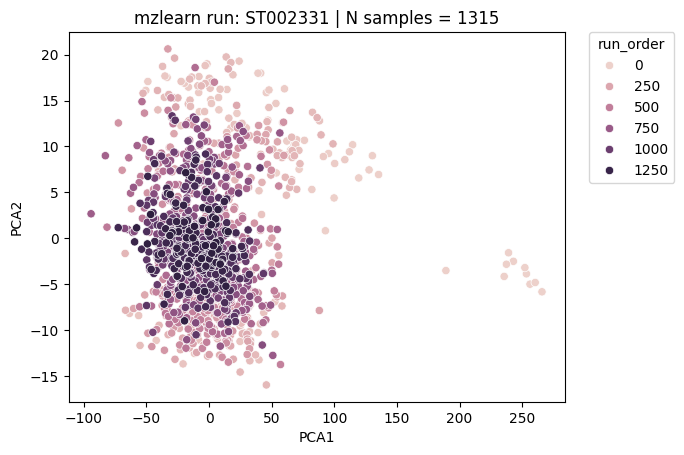

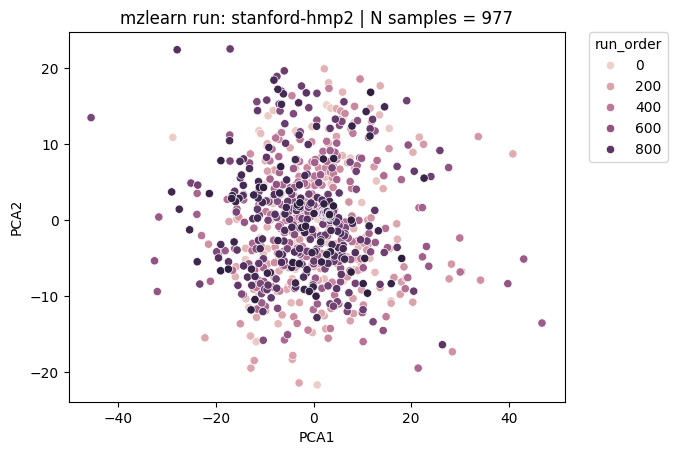

In [26]:
# plot PCA for all mzlearn runs                                        
for mzlearn_run_folder_name, mzlearn_run_id in mzlearn_run_input_folder_names2mzlearn_run_id.items():
    base_dir = f"{input_data_dir}/{mzlearn_run_folder_name}"
    intensity_df_path = f"{base_dir}/scaled_intensity_matrix.csv"
    metadata_df_path = f"{base_dir}/metadata.csv"

    # Check if files exist
    if not os.path.exists(intensity_df_path):
        print(f"File not found: {intensity_df_path}")
    if not os.path.exists(metadata_df_path):
        print(f"File not found: {metadata_df_path}")
    
    # read them as panda df
    intensity_df = pd.read_csv(intensity_df_path, index_col=0)
    metadata_df = pd.read_csv(metadata_df_path, index_col=0)

    # if there is no run_order column in metadata_df
    # create one that is based on the alphabetical order of the index
    if 'run_order' not in metadata_df.columns:
        metadata_df['run_order'] = pd.Categorical(metadata_df.index).codes

    # plot PCA
    embedding0 = generate_pca_embedding(intensity_df.T).values
    plot_pca(mzlearn_run_folder_name, embedding0,metadata_df,col_name='run_order',yes_umap=False)
    

<font size="5"><b>Calculate Robusness for all Peaks from all mzlearn runs</b></font>

/tmp/ipykernel_25/1219329475.py:4: DtypeWarning: Columns (1,28,30,31,32,33,34,46,50,51,52,53,54,55,56,57,58) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata_df = pd.read_csv(f'{input_data_dir}/metadata.csv', index_col=0)


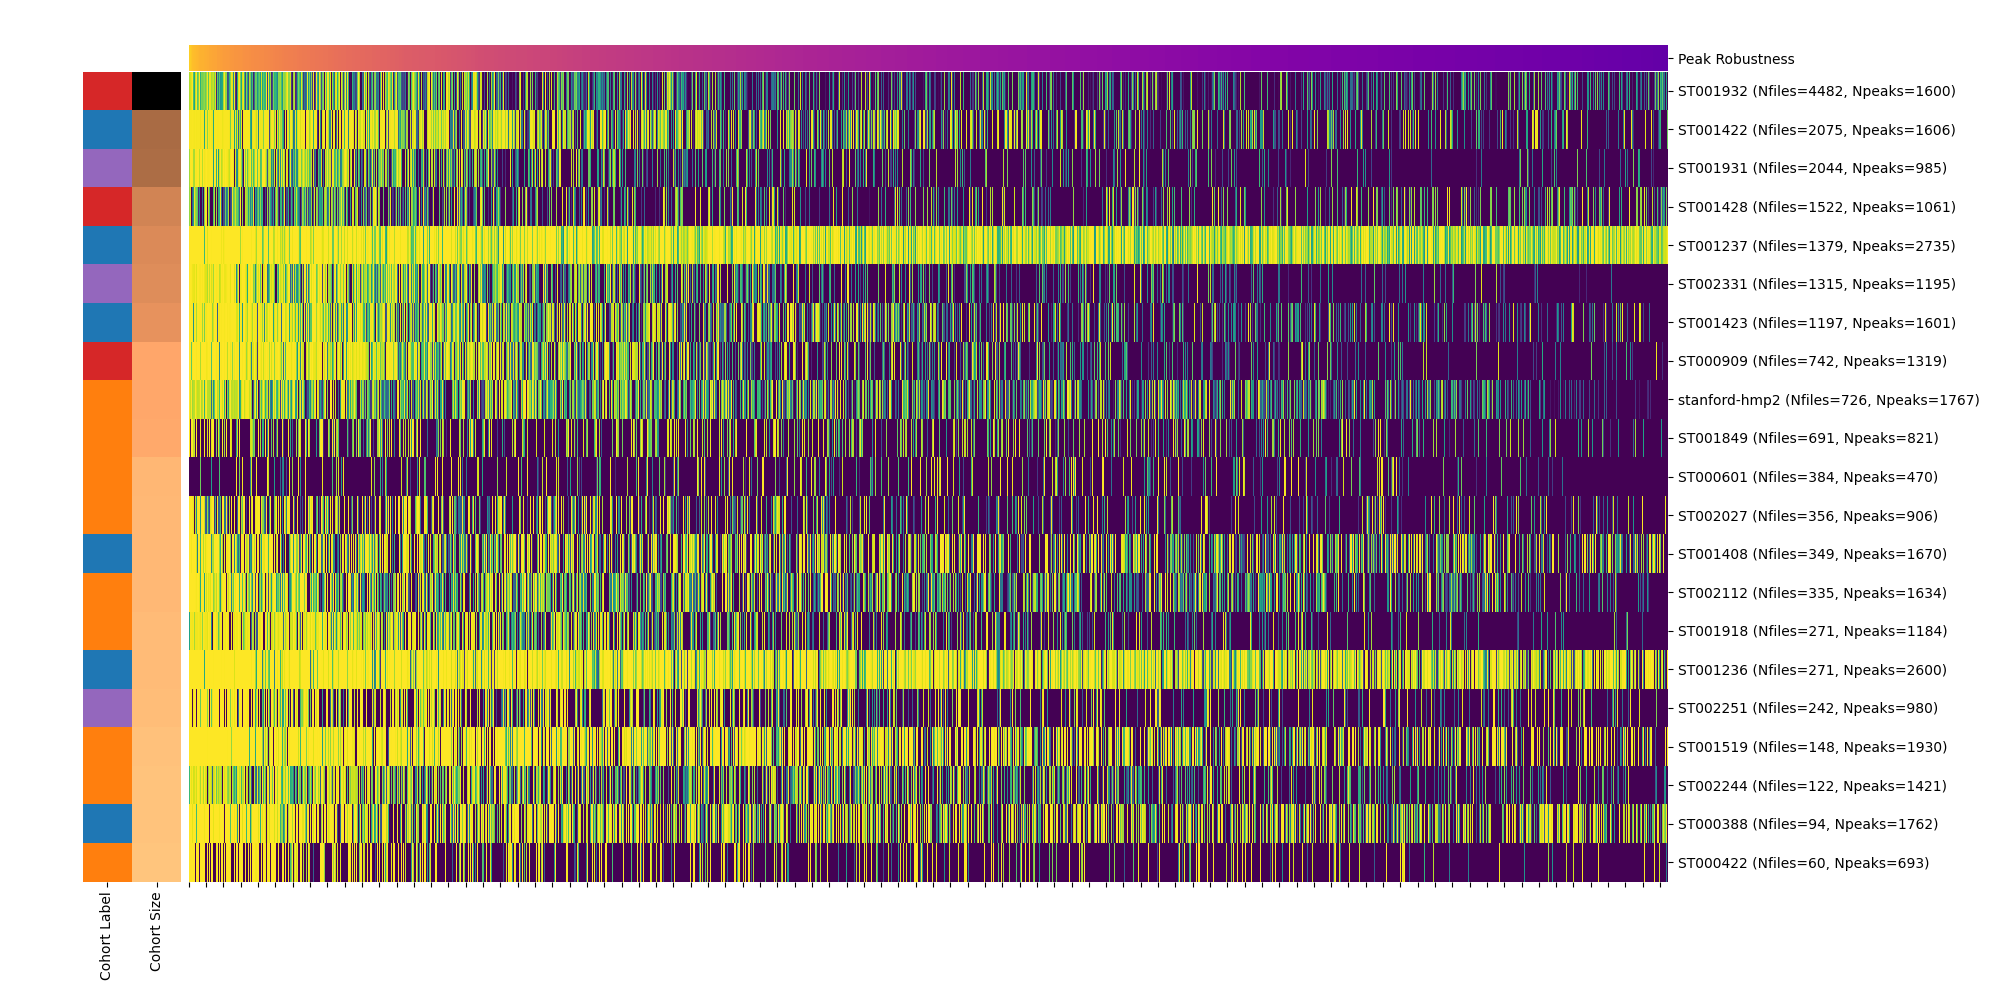

In [46]:
# calcualte robustness for all peaks from all all mzlearn runs

# read in all study metadata and selection df
metadata_df = pd.read_csv(f'{input_data_dir}/metadata.csv', index_col=0)
selections_df = pd.read_csv(f'{input_data_dir}/selection_df.csv',index_col=0)
metadata_df['Set'] = selections_df['Set']
subdir_col = 'Study ID'

# calcualte peak robustness for all peaks
group_sz_dict = {}
freq_of_peaks_by_study = {}
for mzlearn_run_folder_name, mzlearn_run_id in mzlearn_run_input_folder_names2mzlearn_run_id.items():
    nan_file = f'{input_data_dir}/{mzlearn_run_folder_name}/nan_matrix.csv'
    samples_in_cohort = metadata_df[metadata_df[subdir_col]==mzlearn_run_folder_name].index
    nan_matrix = pd.read_csv(nan_file, index_col=0)
    nan_matrix = nan_matrix.loc[samples_in_cohort,:].copy()
    num_samples = nan_matrix.shape[0]
    
    freq_of_peaks = 1 - nan_matrix.mean(axis=0)
    freq_of_samples = 1 - nan_matrix.mean(axis=1)
    
    group_sz_dict[mzlearn_run_folder_name] = num_samples
    freq_of_peaks_by_study[mzlearn_run_folder_name] = freq_of_peaks
group_sz_df = pd.DataFrame(group_sz_dict, index=['N']).T
group_sz_df = group_sz_df.astype(int)
group_freq_df = pd.DataFrame(freq_of_peaks_by_study)
group_log_sz_df = np.log(1 + group_sz_df)
peak_robustness = group_freq_df.mul(group_log_sz_df['N'], axis=1).sum(axis=1)/group_log_sz_df['N'].sum()
# print(peak_robustness)

# create color map for studies and cohort
study_id_to_label = metadata_df.groupby('Study ID')['Cohort Label v0'].first().to_dict()
cohort_label_to_color = assign_color_map(metadata_df['Cohort Label v0'].unique())
study_id_to_color = {k:cohort_label_to_color[v] for k,v in study_id_to_label.items()}
study_id_to_uniq_color = assign_color_map(metadata_df['Study ID'].unique())
group_peak_counts = {}
for mzlearn_run_folder_name, mzlearn_run_id in mzlearn_run_input_folder_names2mzlearn_run_id.items():
    study_id = mzlearn_run_folder_name
    group_peak_counts[study_id] = np.sum(group_freq_df[study_id] > 0) 

feat_info_3 = group_freq_df

col_cluster = False
row_cluster = False
subdir_list = mzlearn_run_input_folder_names2mzlearn_run_id.keys()
plot_df = feat_info_3[subdir_list].T
col_colors = pd.DataFrame(index=plot_df.columns)
for col in feat_info_3.columns:
    if col in subdir_list:
        continue
    col_colors[col] = feat_info_3[col].map({True: 'black', False: 'white'})
col_colors[f'Peak Robustness'] = peak_robustness.map(lambda x: plt.cm.plasma(x))
if col_cluster==False:
    col_val_order = peak_robustness
    col_val_order.sort_values(ascending=False, inplace=True)
    plot_df = plot_df[col_val_order.index]
if row_cluster==False:
    row_val_order = group_sz_df['N'].copy()
    row_val_order.sort_values(ascending=False, inplace=True)
    plot_df = plot_df.loc[row_val_order.index]

# create row colors
row_colors = pd.DataFrame(index=plot_df.index)
row_colors['Cohort Label'] = [study_id_to_color[c] for c in plot_df.index]
row_colors['Cohort Size'] = [group_sz_df.loc[c, 'N'] for c in plot_df.index]
row_colors['Cohort Size'] = row_colors['Cohort Size']/row_colors['Cohort Size'].max()
row_colors['Cohort Size'] = row_colors['Cohort Size'].map(lambda x: plt.cm.copper_r(x))
new_row_names = [f'{c} (Nfiles={group_sz_df.loc[c].values[0]}, Npeaks={group_peak_counts[c]:.0f})' 
        for c in plot_df.index]

plot_df.index =  new_row_names
row_colors.index = new_row_names
# print(plot_df)

g = sns.clustermap(plot_df, cmap='viridis', figsize=(20,10), 
            row_colors=row_colors, col_colors=col_colors, 
            col_cluster=col_cluster, row_cluster=row_cluster,
            dendrogram_ratio=0.04)

plt.setp(g.ax_heatmap.get_xticklabels(), visible=False)
g.cax.set_visible(False)

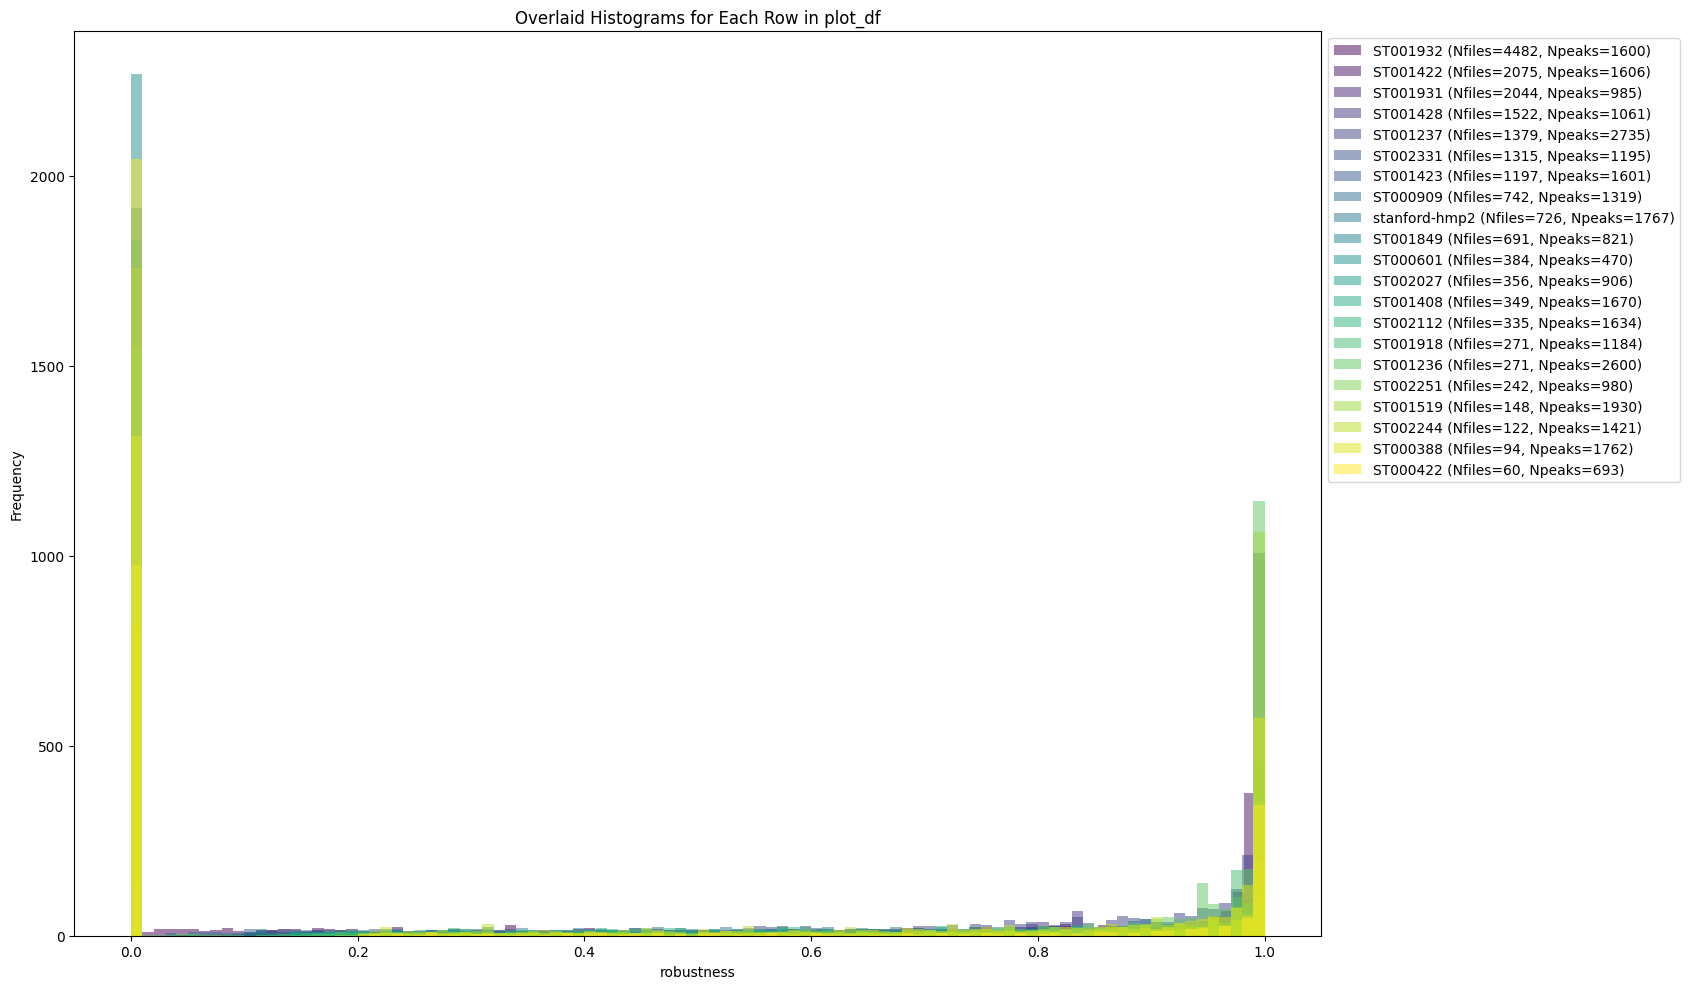

In [59]:
# plot the histogram of peak robustness
# Function to plot overlaid histograms for each row in plot_df
def plot_overlaid_histograms(df):
    plt.figure(figsize=(20, 10))
    colors = plt.cm.viridis(np.linspace(0, 1, df.shape[0]))  # Generate a range of colors
    for idx, (row_name, row_data) in enumerate(df.iterrows()):
        plt.hist(row_data, bins=100, color=colors[idx], alpha=0.5, label=row_name)
    
    plt.xlabel('robustness')
    plt.ylabel('Frequency')
    plt.title('Overlaid Histograms for Each Row in plot_df')
    
    # Place the legend outside the plot
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to make room for the legend
    plt.show()


# Example usage with plot_df
plot_overlaid_histograms(plot_df)

<font size="5"><b>Plot Histogram of all Meta data</b></font>

/tmp/ipykernel_25/2225562957.py:2: DtypeWarning: Columns (1,28,30,31,32,33,34,46,50,51,52,53,54,55,56,57,58) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata_df = pd.read_csv(f'{input_data_dir}/metadata.csv', index_col=0)


<Axes: xlabel='Cancer Risk', ylabel='Count'>

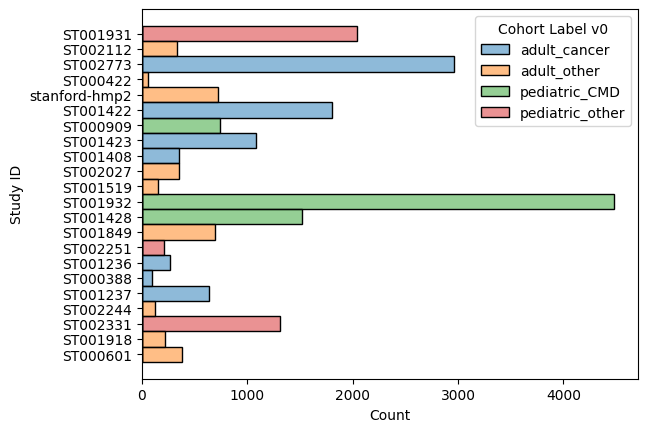

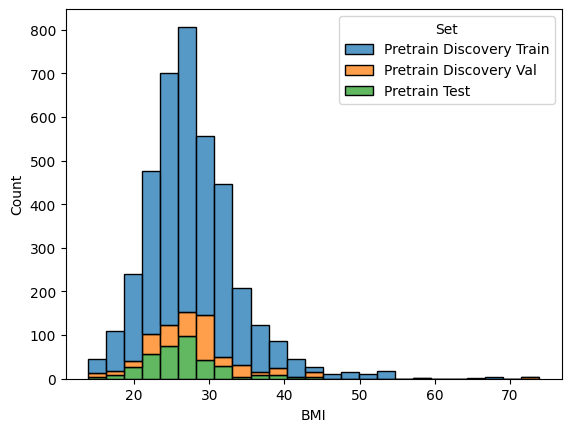

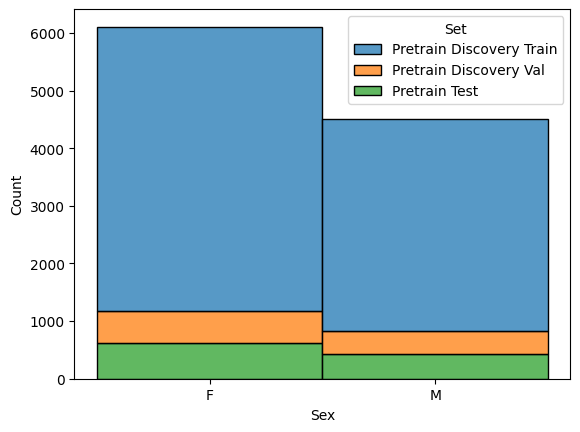

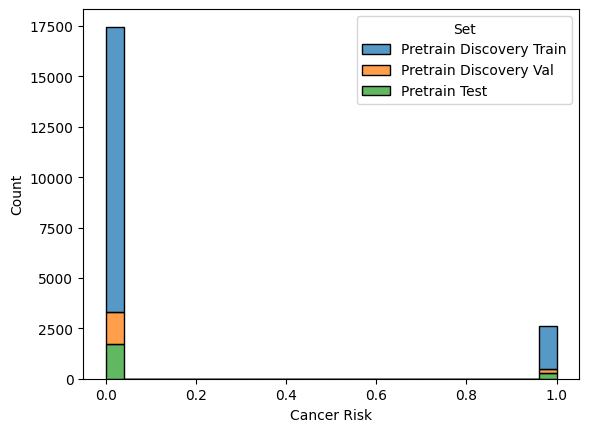

In [64]:
# read in all study metadata and selection df
metadata_df = pd.read_csv(f'{input_data_dir}/metadata.csv', index_col=0)
selections_df = pd.read_csv(f'{input_data_dir}/selection_df.csv',index_col=0)
metadata_df['Set'] = selections_df['Set']
subdir_col = 'Study ID'

pretrain_metadata = metadata_df[metadata_df['Set'].str.contains('Pretrain')]
cohort_order = pretrain_metadata['Cohort Label v0'].value_counts().sort_index().index.tolist()
plt.figure()
sns.histplot(y='Study ID', hue='Cohort Label v0', data=pretrain_metadata,hue_order=cohort_order)

hue_order=['Pretrain Discovery Train','Pretrain Discovery Val','Pretrain Test']
plt.figure()
sns.histplot(data=pretrain_metadata,x='BMI', hue = 'Set',multiple='stack',bins=25,hue_order=hue_order)

plt.figure()
sns.histplot(data=pretrain_metadata,x='Sex', hue = 'Set',multiple='stack',bins=25,hue_order=hue_order)

plt.figure()
sns.histplot(data=pretrain_metadata,x='Cancer Risk', hue = 'Set',multiple='stack',bins=25,hue_order=hue_order)

<font size="5"><b>Plot the UMAP for all Inputs</b></font>

/tmp/ipykernel_25/2864451165.py:3: DtypeWarning: Columns (1,28,30,31,32,33,34,46,50,51,52,53,54,55,56,57,58) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata_df = pd.read_csv(f'{input_data_dir}/metadata.csv', index_col=0)
/tmp/ipykernel_25/2687912780.py:140: DtypeWarning: Columns (1,28,30,31,32,33,34,46,50,51,52,53,54,55,56,57,58) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata_df = pd.read_csv(f'{input_data_dir}/metadata.csv', index_col=0)


Number of samples selected: 16862
Files already exist at /app/PROCESSED_DATA
Number of samples in Discovery Train: 14231


Text(0.5, 1.0, 'pretrain Latent Space of Discovery Train (N=14231)')

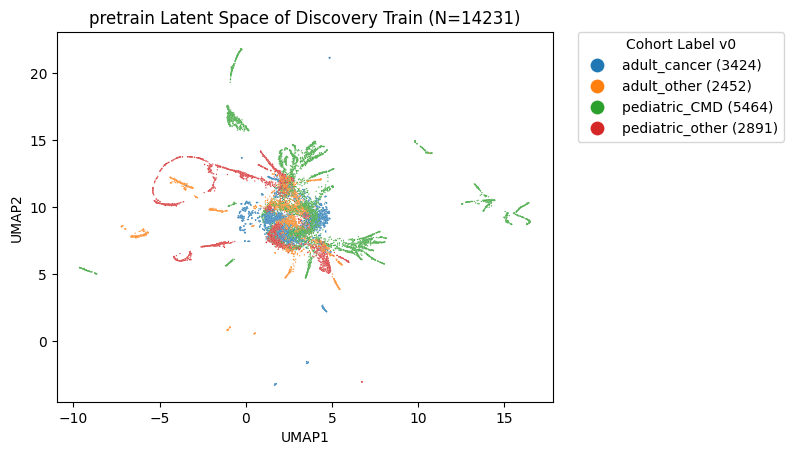

In [65]:
# plot the UMAP for all inputs
# read in all study metadata and selection df
metadata_df = pd.read_csv(f'{input_data_dir}/metadata.csv', index_col=0)
selections_df = pd.read_csv(f'{input_data_dir}/selection_df.csv',index_col=0)
metadata_df['Set'] = selections_df['Set']
subdir_col = 'Study ID'

pretrain_metadata = metadata_df[metadata_df['Set'].str.contains('Pretrain')]
cohort_order = pretrain_metadata['Cohort Label v0'].value_counts().sort_index().index.tolist()

hue_col = 'Cohort Label v0'
eval_name = 'Discovery Train'
setup_id = 'Scaled Intensity Data'

fit_subset_col = 'Pretrain Discovery Train'
eval_subset_col = 'Pretrain Discovery Val'
setup_id = 'pretrain'

# create the train data
_, fit_file_id = create_selected_data(input_data_dir=input_data_dir,
                                      sample_selection_col=fit_subset_col,
                                      subdir_col=subdir_col,
                                      output_dir=output_dir,
                                      metadata_df=None,
                                      selections_df=selections_df)

X_data_path = f'{output_dir}/X_{fit_file_id}.csv'
y_data_path = f'{output_dir}/y_{fit_file_id}.csv'
X_data = pd.read_csv(X_data_path, index_col=0)
y_data = pd.read_csv(y_data_path, index_col=0)

# plot umap
Z_umap = generate_umap_embedding(X_data)
Z_umap.columns = ['UMAP1', 'UMAP2']
Z_embed = Z_umap.join(y_data)
# Get the counts for each instance of the hue column, and the corresponding colormap
Z_count_sum = (~Z_embed[hue_col].isnull()).sum()
print(f'Number of samples in {eval_name}: {Z_count_sum}')
if Z_count_sum < 10:
    print('too few to plot')

if Z_embed[hue_col].nunique() > 30:
    # if more than 30 unique values, then assume its continuous
    palette = 'flare'
    Z_counts = None
else:
    # if fewer than 30 unique values, then assume its categorical
    # palette = get_color_map(Z_embed[hue_col].nunique())
    palette = assign_color_map(Z_embed[hue_col].unique())
    Z_counts = Z_embed[hue_col].value_counts()

plot_title = f'{setup_id} Latent Space of {eval_name} (N={Z_count_sum})'
# choose the marker size based on the number of nonnan values
# marker_sz = 10/(1+np.log(Z_count_sum))
marker_sz = 100/np.sqrt(Z_count_sum)

## UMAP ##
fig = sns.scatterplot(data=Z_embed, x='UMAP1', y='UMAP2', hue=hue_col, palette=palette,s=marker_sz,hue_order=cohort_order)
# place the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# edit the legend to include the number of samples in each cohort
handles, labels = fig.get_legend_handles_labels()

# Add the counts to the legend if hue_col is categorical
if Z_counts is not None:
    # new_labels = [f'{label} ({Z_embed[Z_embed[hue_col]==label].shape[0]})' for label in labels]
    new_labels = []
    for label in labels:
        # new_labels.append(f'{label} ({Z_counts.loc[eval(label)]})')
        try:
            new_labels.append(f'{label} ({Z_counts.loc[label]})')
        except KeyError:
            new_labels.append(f'{label} ({Z_counts.loc[eval(label)]})')
else:
    new_labels = labels

# make the size of the markers in the handles larger
for handle in handles:
    # print(dir(handle))
    handle.set_markersize(10)
    # handle._sizes = [100]

plt.legend(handles, new_labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title=hue_col)

plt.title(plot_title)